# 8-5. 프로젝트 : 개선된 U-Net 모델 만들기


U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느 정도 동작하는 것 같긴 하지만 좀 더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다. 논문은 2020년에 한 번 업그레이드가 되었네요.

- U-Net++: v1
    - https://arxiv.org/abs/1807.10165
- U-Net++: v2
    - https://arxiv.org/abs/1912.05074
    
모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해 보면 될 것입니다.

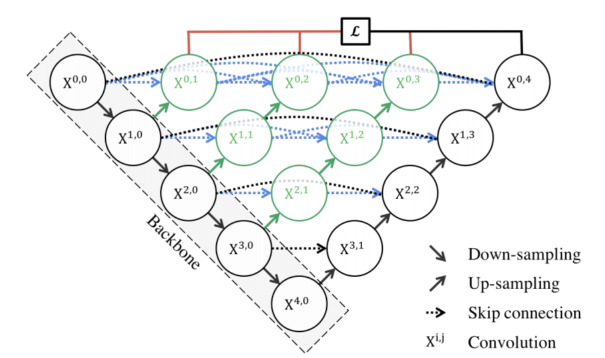

참고할 수 있는 코드는 아래에 있습니다. 다행히도 keras로 구현되어 있습니다.

- U-Net++:Github
    - https://github.com/MrGiovanni/UNetPlusPlus
    
코드 중에서 가장 중요한 부분도 알려드리자면 여기:build_xnet입니다. 논문에서 제시하는 수식과 함께 참고하세요.

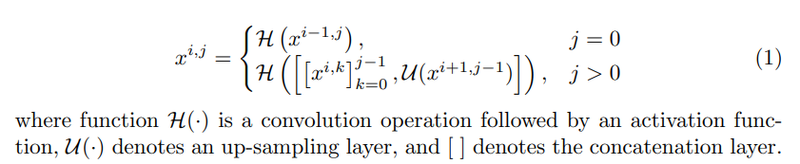

코드 중 up_block으로는 두 가지 방식을 사용하고 있네요. Transpose2D_block과 Upsample2D_block인데요. 둘 중 어느 것을 사용해도 좋습니다.

또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점입니다. binary cross-entropy와 dice coefficient를 사용한다고 하는데요. dice_coef에 구현된 dice coefficient를 참고해 보세요.

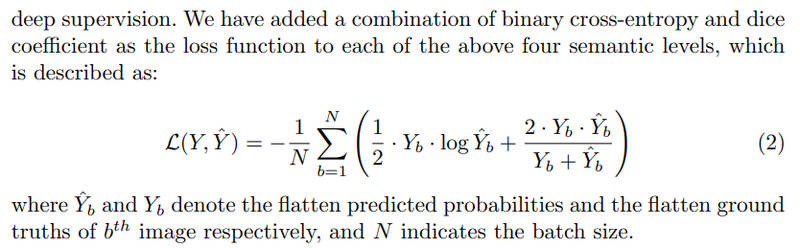

프로젝트 진행에 필요한 주요 라이브러리 버전 체크를 해봅시다.






In [1]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

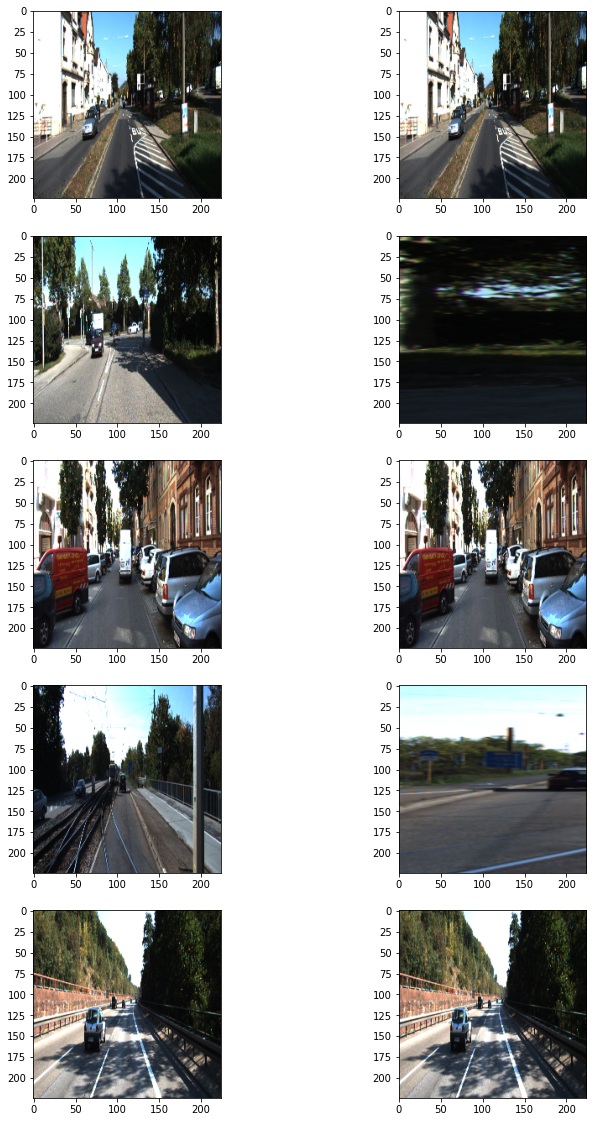

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [4]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [5]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

## Step 1. KITTI 데이터셋 수집과 구축
다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [7]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

- https://github.com/MrGiovanni/UNetPlusPlus/blob/master/keras/helper_functions.py 참고

In [8]:
import keras
import tensorflow as tf
from keras.models import Model
from keras import backend as K
from keras.layers import Input, merge, Conv2D, ZeroPadding2D, UpSampling2D, Dense, concatenate, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Dropout, Flatten, Lambda
from keras.layers.advanced_activations import ELU, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras.layers.noise import GaussianDropout

In [9]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'
    dropout_rate = 0.5

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

def UNetPlusPlus(input_shape=(224, 224, 3), num_class=1, deep_supervision=False):
    nb_filter = [64,128,256,512,1024]
    
    img_input = Input(input_shape, name='main_input')
    bn_axis = 3
    
    conv1_1 = standard_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)
    
    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)
    
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)

    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])
    
    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)

    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])
    
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)
    

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])
    

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)

    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])
    

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)

    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])
    
  
    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)

    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])
    
    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
  
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])
    

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)

    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])
    
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)

    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])
    
    nesnet_output_1 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nesnet_output_2 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nesnet_output_3 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nesnet_output_4 = Conv2D(num_class, (1,1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)
    
    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nesnet_output_1,
                                              nesnet_output_2,
                                              nesnet_output_3,
                                              nesnet_output_4])
    else:
        model = Model(inputs=img_input, outputs = [nesnet_output_4])
        
    return model

In [10]:
model_UNetPlusPlus = UNetPlusPlus(input_shape=(224,224,3))
model_UNetPlusPlus.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 224, 224, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
dp11_1 (Dropout)                (None, 224, 224, 64) 0           conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 224, 224, 64) 36928       dp11_1[0][0]                     
______________________________________________________________________________________________

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

### U-Net++

In [11]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetplusplus.h5'

model_UNetPlusPlus = UNetPlusPlus()
model_UNetPlusPlus.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model_UNetPlusPlus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_UNetPlusPlus.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 43s 641ms/step - loss: 2.1988 - val_loss: 3.0929
Epoch 2/100
43/43 [==============================] - 25s 591ms/step - loss: 1.6665 - val_loss: 2.5181
Epoch 3/100
43/43 [==============================] - 25s 590ms/step - loss: 1.5816 - val_loss: 2.5034
Epoch 4/100
43/43 [==============================] - 26s 604ms/step - loss: 1.5145 - val_loss: 2.9609
Epoch 5/100
43/43 [==============================] - 26s 603ms/step - loss: 1.4734 - val_loss: 2.1525
Epoch 6/100
43/43 [==============================] - 26s 597ms/step - loss: 1.4015 - val_loss: 2.2888
Epoch 7/100
43/43 [==============================] - 26s 600ms/step - loss: 1.3381 - val_loss: 2.3543
Epoch 8/100
43/43 [==============================] - 26s 602ms/step - loss: 1.2886 - val_loss: 3.1524
Epoch 9/100
43/43 [==============================] - 26s 602ms/step - loss: 1.2329 - val_loss: 2.1547
Epoch 10/100
43/43 [==============================] - 26s 599ms/step - loss: 1.200

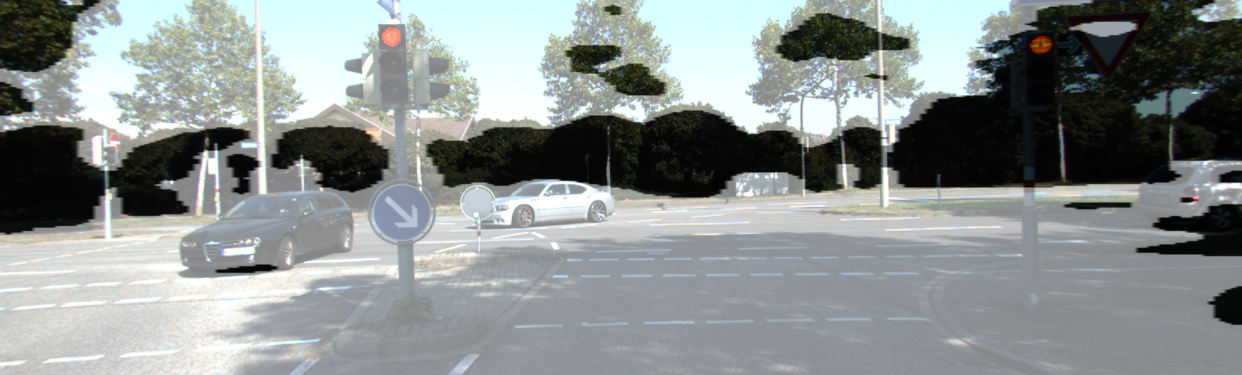

IoU : 0.373906


0.3739061676331049

In [19]:
from keras.models import load_model

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 11    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_UNetPlusPlus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### U-Net

In [13]:
# 저장된 U-Net 모델 불러오기
from keras.models import load_model
model = load_model(dir_path + '/seg_model_unet.h5')

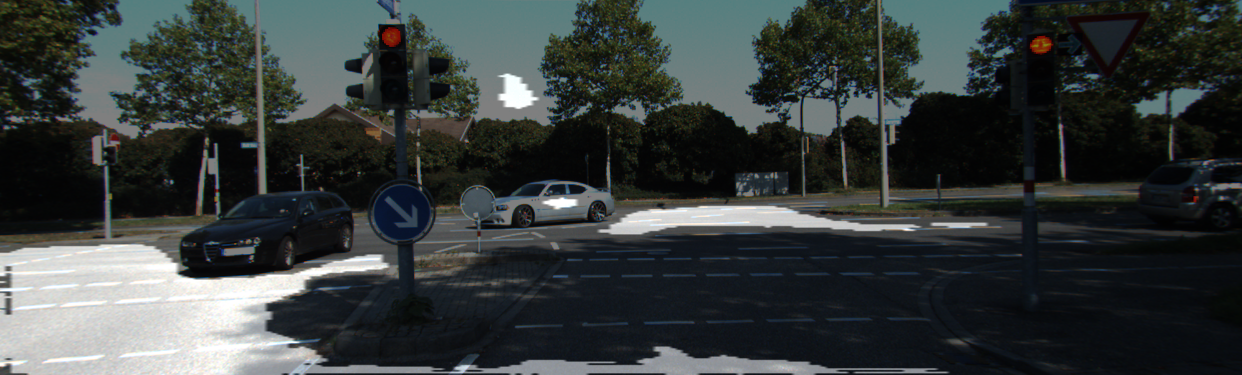

IoU : 0.339661


0.3396606869698234

In [20]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 11    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

## 프로젝트 결과 및 회고
- 이번 프로젝트는 U-Net과 U-Net++를 구현하여 Kitti 데이터셋을 활용해 이미지의 도로 영역을 구분하는 프로젝트 입니다.
- 처음 과정으로 U-Net++를 주어진 개요를 따라 구현해 보고자 하였으나 실제 github에 구현된 U-Net++와 비슷하게 만들 수 없었습니다. 그래서 github에 구현된 원본의 U-Net++를 베이스로 가져와서 프로젝트를 진행하였습니다.
- 또한 노드에서 구현했던 U-Net 모델을 가져와서 결과를 비교하는 방식으로 프로젝트를 진행하였는데 마무리를 하고보니 U-Net의 경우에는 batch_size를 16으로 상대적으로 크게 구현했었고 U-Net++의 경우 메모리 오류가 발생하여 4로 상대적으로 작게 구현했는데 이러한 차이 때문에 완벽하게 두 모델을 동일한 조건에서 비교할 수 없었다고 생각합니다.
- 동일하지 못한 조건이지만 결과를 비교해보면 U-Net++의 IoU가 U-Net의 IoU보다 소폭 높았지만 찾아본 다른 사람의 결과보다 현저하게 낮은 수준의 IoU를 가진 것을 확인하였습니다. 실제 학습을 돌릴 때 생각보다 많은 시간이 소요되어서 노드 마감 기한을 고려하여 일단 현재의 결과를 제출하지만 주말을 통해 다른 사람들의 결과처럼 높은 수준의 IoU를 받을 수 있도록 제가 구현한 모델의 문제를 개선할 예정입니다.